In [51]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 12,
          'figure.figsize': (10, 10),
         'axes.labelsize': 12,
         'axes.titlesize': 12,
         'xtick.labelsize':12,
         'ytick.labelsize':12}
plt.rcParams.update(params) 

from sympy.solvers import solve

from sympy import Symbol, Function, nsolve 

Se desea un filtro de paso de banda centrado en $250 MHz$ que tenga un ancho de banda de $3dB$ de $40 MHz$. 

-
Además, suponga que el nivel de impedancia del filtro $R_s =200$.

La capacitancia de sintonización requerida es
$$C_t  =   \frac{1}{ \pi  \sqrt{2} R B}$$



Los inductores de resonancia de derivación $_{eff}$ 
$$L_{eff}  =  [\omega C_t  -  \frac{1}{2 R^2 C_t}]^{-1}$$


El inductor de acoplamiento 
$$L_{c}  = \frac{R}{ \omega_c} =127,3 nH.$$
 

El valor para $L_r$ 
$$L_{r}  =  \frac{L_{eff} L_c}{L_c + L_{eff}} = 16.36 nH$$
 



In [52]:
def calcC(w,ro,rg,ct  ):
    
    a   = -w**2*ro*rg
    b   = 1/ct
    d   = rg/ro
    
    aa  = (d-b**2/a)/(1+b**2/a-d)
    bb  = (b/a)/(1+b**2/a-d)
    
    
    c1  = Symbol('c1')

    f   = a*aa*c1**2+(a*bb+b+b*aa)*c1 +(b*bb-1)  
    c1s = solve( f  , c1)

    c1p   = [c  for c in c1s if c>0 ][0] 
    c2    = aa*c1p+bb
    return c1p,c2


def AvTeR(w,rs,C1,C2,Lc,Lr,rl):
    zl =   rl + 1/(w*C1*1j)
    y1 = 1/zl +   (w*C2*1j)
    z2 = 1/y1 +   (w*Lr*1j)
    y3 = 1/z2 + 1/(w*Lc*1j)
    z4 = 1/y3 +   (w*Lr*1j)
    y5 = 1/z4 +   (w*C2*1j)
    zi = 1/y5 + 1/(w*C1*1j)
    
    return (np.abs(1/(rs+zi)/y5/z4/y3/z2/y1/zl*rl ))    



def calcVr(Cj, Cjo, Vj, M, Cp, Rs, Ls):
    return (((Cjo)/(Cj-Cp))**(1/M)-1)*Vj


smv = dict()
# CJO(F) VJ(V) M CP(F) RS(Ω) Ls(Hy)
smv['SMV1234'] = ( 8.36e-12,   7.95,  3.96,  1.15e-12,  0.80, 1.4e-9)
smv['SMV2022'] = ( 7.30e-12,   4.00,  1.40,         0,   2.2, 1.5e-9)
smv['SMV1253'] = ( 51.8e-12,  73.60,  48.7,  2.70e-12,   1.1, 1.4e-9)
smv['SMV1213'] = ( 28.9e-12, 190.00, 105.0,  2.20e-12,   1.4, 1.5e-9)  
smv['SMV1470'] = (110.0e-12,  80.00,  39.7,  3.94e-12,   0.5, 1.4e-9)  
        

In [60]:
finf = 20e6
fsup = 40e6

# Inductores
Qo = 100

fg = (finf*fsup)**(1/2)
wg = 2*np.pi*fg
B =  3e6
rg = 20
ro = 50
rl = 50
rs = 50
gamma = 1

In [61]:
Lc   = rg/wg
Leff = rg/(np.pi*2**(1/2)*B)
Ctg  =  1/(wg**2*Leff)
Lr   = Leff - Lc 


print('.param rs =  {:2.1f} '.format(ro) )
print('.param rl =  {:2.1f} '.format(ro) )


rpc  = wg*Lc/Qo
print('.param Lc  =  {:3.2f}n'.format(Lc/1e-9) )
print('.param rpc =  {:2.1f} '.format(rpc) )

rpr  = wg*Lr*Qo
print('.param Lr =  {:3.2f}n'.format(Lr/1e-9) )
print('.param rpr =  {:2.1f} '.format(rpr) )

f = fg
# finf , fsup 
Cti     = Ctg*(fg/f)**2
rgi     = rg*(f/fg)**gamma
C1,C2 = calcC(2*np.pi*f,ro,rgi,Cti )
print('.param C1 =  {:3.3f}p'.format(C1/1e-12) )
print('.param C2 =  {:3.3f}p'.format(C2/1e-12) )


.param rs =  50.0 
.param rl =  50.0 
.param Lc  =  112.54n
.param rpc =  0.2 
.param Lr =  1387.99n
.param rpr =  24666.7 
.param C1 =  7.768p
.param C2 =  13.402p


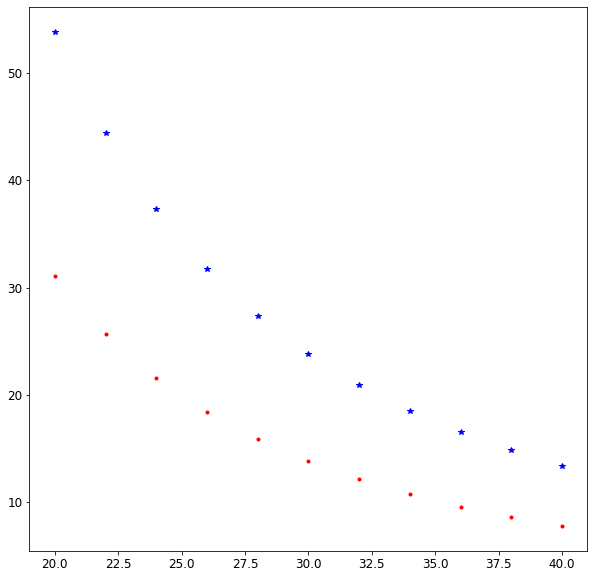

In [62]:
step = 2e6
freq = np.arange(finf,fsup+step,step)



for f in freq:
    Cts   = Ctg*(fg/f)**2

    C1,C2 = calcC(2*np.pi*f,ro,rg,Cts )
     
    
    plt.plot(f/1e6,C1*2/1e-12,'r.')
    plt.plot(f/1e6,C2*2/1e-12,'b*')
plt.show()    

In [63]:
step = 2e6
freq = np.arange(finf,fsup+step,step)

cjo1, vj1, m1, cp1, rs1, ls1 = smv['SMV1253']
cjo2, vj2, m2, cp2, rs2, ls2 = smv['SMV1253']

print('.param Cjo1 =  {:2.1e} '.format(cjo1) )
print('.param Vj1  =  {:2.1e} '.format(vj1) )
print('.param M1   =  {:2.1e} '.format(m1) )
print('.param Cp1  =  {:2.1e} '.format(cp1) )
print('.param Rs1  =  {:2.1e} '.format(rs1) )
print('.param Ls1  =  {:2.1e} '.format(ls1) )

print('.param Cjo2 =  {:2.1e} '.format(cjo2) )
print('.param Vj2  =  {:2.1e} '.format(vj2) )
print('.param M2   =  {:2.1e} '.format(m2) )
print('.param Cp2  =  {:2.1e} '.format(cp2) )
print('.param Rs2  =  {:2.1e} '.format(rs2) )
print('.param Ls2  =  {:2.1e} '.format(ls2) )



.param Cjo1 =  5.2e-11 
.param Vj1  =  7.4e+01 
.param M1   =  4.9e+01 
.param Cp1  =  2.7e-12 
.param Rs1  =  1.1e+00 
.param Ls1  =  1.4e-09 
.param Cjo2 =  5.2e-11 
.param Vj2  =  7.4e+01 
.param M2   =  4.9e+01 
.param Cp2  =  2.7e-12 
.param Rs2  =  1.1e+00 
.param Ls2  =  1.4e-09 


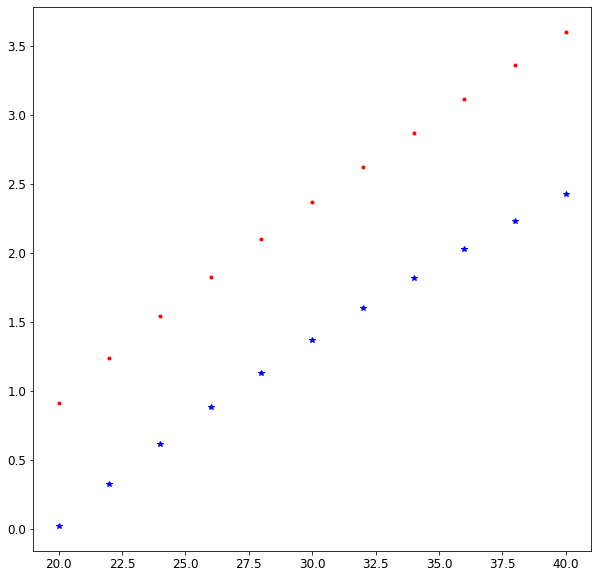

In [64]:
for f in freq:
    Cts   = Ctg*(fg/f)**2

    C1,C2 = calcC(2*np.pi*f,ro,rg,Cts )
    #print(f)
    Vr1   = calcVr(C1*2,cjo1, vj1, m1, cp1, rs1, ls1) 
    Vr2   = calcVr(C2*2,cjo2, vj2, m2, cp2, rs2, ls2) 
    #print(Vr1, Vr2)
    plt.plot(f/1e6,Vr1,'r.')
    plt.plot(f/1e6,Vr2,'b*')
plt.show()    


In [65]:
f = 40e6
Cts   = Ctg*(fg/f)**2

C1,C2 = calcC(2*np.pi*f,ro,rg,Cts )
Vr1   = calcVr(C1*2,cjo1, vj1, m1, cp1, rs1, ls1) 
Vr2   = calcVr(C2*2,cjo2, vj2, m2, cp2, rs2, ls2)

 

print('.param Vs =  {:3.3f}'.format(Vr1) )
print('.param Vd =  {:3.3f}'.format(Vr2) )

.param Vs =  3.600
.param Vd =  2.426


3.68004366957384e-11 1.81820463253677e-11
2.89497332573753e-11 1.40908549111422e-11
2.33773443404753e-11 1.12617773480788e-11
1.92768644456527e-11 9.21757939268377e-12
1.61706168799732e-11 7.68945218213289e-12


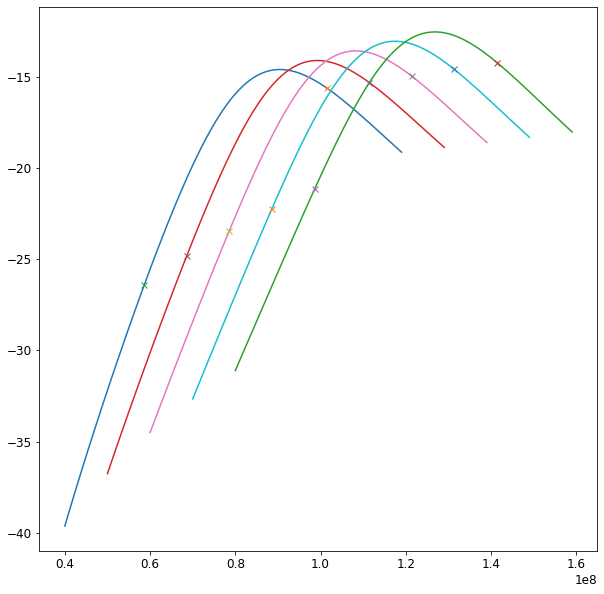

In [8]:
step = 10e6
freq = np.arange(80e6,120e6+step,step)
df = np.arange(-40e6,40e6,1e6)


for f in freq:
    Cts   = Ctg*(fg/f)**2
    C1,C2 = calcC(2*np.pi*f,rs,rg,Cts )    
    print(C1,C2)
    plt.plot(f+df      ,([20*mt.log10(AvTeR(2*np.pi*(f+fi),rs,C1,C2,Lc,Lr,rl)) for fi in df]))
    plt.plot(f+2*10.7e6,20*mt.log10(AvTeR(2*np.pi*(f+2*10.7e6),rs,C1,C2,Lc,Lr,rl)),'x')
    plt.plot(f-2*10.7e6,20*mt.log10(AvTeR(2*np.pi*(f-2*10.7e6),rs,C1,C2,Lc,Lr,rl)),'x')
    
plt.show() 